NLP - twitter

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import re
import sklearn
import string

import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_csv('tweets.csv')

In [33]:
df.shape

(14640, 15)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [193]:
df.isnull().sum()/len(df)*100

tweet_id                        0.000000 
airline_sentiment               0.000000 
airline_sentiment_confidence    0.000000 
negativereason                  37.308743
negativereason_confidence       28.128415
airline                         0.000000 
airline_sentiment_gold          99.726776
name                            0.000000 
negativereason_gold             99.781421
retweet_count                   0.000000 
text                            0.000000 
tweet_coord                     93.039617
tweet_created                   0.000000 
tweet_location                  32.329235
user_timezone                   32.923497
normalized_tweet                0.000000 
multi_grams                     0.000000 
dtype: float64

In [7]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [8]:
df.retweet_count.value_counts()

0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
9         1
31        1
18        1
15        1
28        1
44        1
11        1
Name: retweet_count, dtype: int64

In [211]:
# Retweets

tweet_df = df.sort_values(by='retweet_count', ascending=False)
tweet_df = tweet_df.reset_index(drop=True)
print('Mean retweets:', round(tweet_df['retweet_count'].mean(),2)), '\n'
print('Top 5 Retweeted tweets:')
print('------------------')
for i in range(5):
    print(tweet_df['text'].loc[i], '-', tweet_df['retweet_count'].loc[i])
print('\n')

Mean retweets: 0.08
Top 5 Retweeted tweets:
------------------
@USAirways 5 hr flight delay and a delay when we land . Is that even real life ? Get me off this plane , I wanna go home 👠👠👠 (3 heel clicks) - 44
@USAirways of course never again tho . Thanks for tweetin ur concern but not Doin anythin to fix what happened. I'll choose wiser next time - 32
STOP. USING.THIS.WORD. IF. YOU'RE. A. COMPANY. RT @JetBlue: Our fleet's on fleek. http://t.co/Fd2TNYcTrB - 31
@USAirways with this livery back in the day. http://t.co/EEqWVAMmiy - 28
@SouthwestAir beautiful day in Seattle! http://t.co/iqu0PPVq2S - 22




In [223]:
import operator

# Hashtags & mentions
tag_dict = {}
mention_dict = {}

for i in tweet_df.index:
    tweet_text = tweet_df.loc[i]['text']
    tweet = tweet_text.lower()
    tweet_tokenized = tweet.split()

    for word in tweet_tokenized:
        # Hashtags - tokenize and build dict of tag counts
        if (word[0:1] == '#' and len(word) > 1):
            key = word.translate(str.maketrans("","", string.punctuation))
            if key in tag_dict:
                tag_dict[key] += 1
            else:
                tag_dict[key] = 1

        # Mentions - tokenize and build dict of mention counts
        if (word[0:1] == '@' and len(word) > 1):
            key = word.translate(str.maketrans("","", string.punctuation))
            if key in mention_dict:
                mention_dict[key] += 1
            else:
                mention_dict[key] = 1

# The 10 most popular tags and counts
top_tags = dict(sorted(tag_dict.items(), key=operator.itemgetter(1), reverse=True)[:10])
top_tags_sorted = sorted(top_tags.items(), key=lambda x: x[1])[::-1]
print('Top 10 hashtags:')
print('----------------')
for tag in top_tags_sorted:
    print(tag[0], '-', str(tag[1]))
    
# The 10 most popular mentions and counts
top_mentions = dict(sorted(mention_dict.items(), key=operator.itemgetter(1), reverse=True)[:10])
top_mentions_sorted = sorted(top_mentions.items(), key=lambda x: x[1])[::-1]
print('\nTop 10 mentions:')
print('----------------')
for mention in top_mentions_sorted:
    print(mention[0], '-', str(mention[1]))

Top 10 hashtags:
----------------
destinationdragons - 79
fail - 69
jetblue - 47
unitedairlines - 45
customerservice - 36
usairways - 30
neveragain - 27
americanairlines - 26
usairwaysfail - 26
united - 25

Top 10 mentions:
----------------
united - 3827
usairways - 2972
americanair - 2913
southwestair - 2426
jetblue - 2092
virginamerica - 506
delta - 68
imaginedragons - 45
jetblues - 27
phlairport - 20


In [31]:
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

Text(0.5,1,'Tweets per Airline')

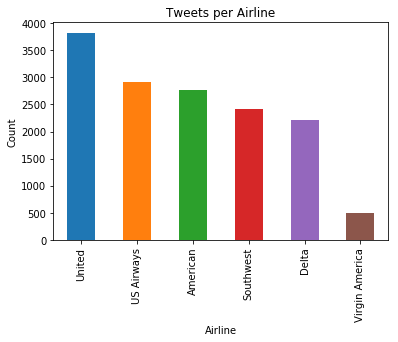

In [34]:
df.airline.value_counts().plot(kind = "bar")
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Tweets per Airline')

Text(0.5,1,'Categories of Sentiments')

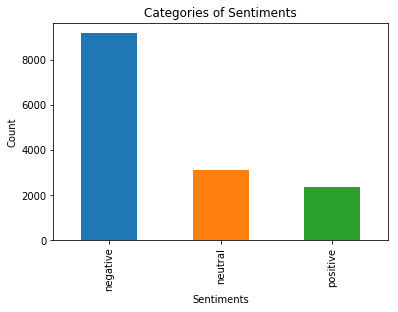

In [30]:
df.airline_sentiment.value_counts().plot(kind = "bar")
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Categories of Sentiments')

Text(0.5,1,'Sentiment by Airline')

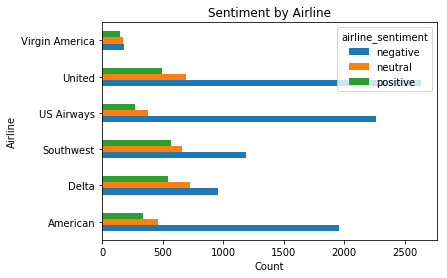

In [3]:
airline_sentiment=pd.crosstab(df.airline, df.airline_sentiment).plot(kind='barh')
airline_sentiment
plt.xlabel('Count')
plt.ylabel('Airline')
plt.title('Sentiment by Airline')

# Add Ratio comparison

In [49]:
air_sentiment=pd.crosstab(df.airline, df.airline_sentiment)
air_sentiment

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


Text(0.5,1,'Sentiment by Airline - Stacked')

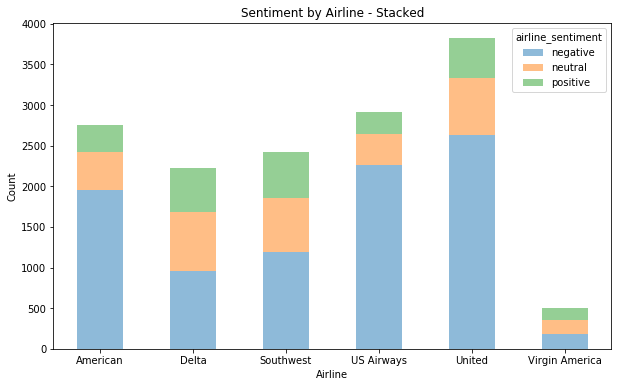

In [55]:
pd.crosstab(index = df.airline, columns = df.airline_sentiment).plot(kind='bar',
                figsize=(10, 6),alpha=0.5,rot=0,stacked=True)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Sentiment by Airline - Stacked')

In [50]:
sent_percent=air_sentiment.apply(lambda a: a / a.sum() * 100, axis=1)
sent_percent

airline_sentiment,negative,neutral,positive
airline,,,
American,71.040232,16.781443,12.178325
Delta,42.979298,32.538254,24.482448
Southwest,49.008264,27.438017,23.553719
US Airways,77.686234,13.079300,9.234466
United,68.890633,18.236525,12.872841
Virgin America,35.912698,33.928571,30.158730


Text(0.5,1,'Sentiment by Airline - Ratio')

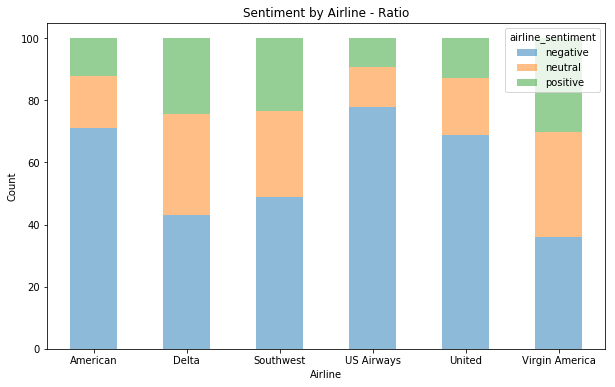

In [54]:
sent_percent.plot(kind='bar', figsize=(10, 6), alpha=0.5, rot=0, stacked=True)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Sentiment by Airline - Ratio')

In [5]:
df.negativereason.describe()

count                       9178
unique                        10
top       Customer Service Issue
freq                        2910
Name: negativereason, dtype: object

In [6]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [65]:
df.negativereason.replace('longlines','Long Lines', inplace = True)

In [66]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
Long Lines                      178
Damaged Luggage                  74
Name: negativereason, dtype: int64

Text(0.5,1,'Categories of Negative Reasons')

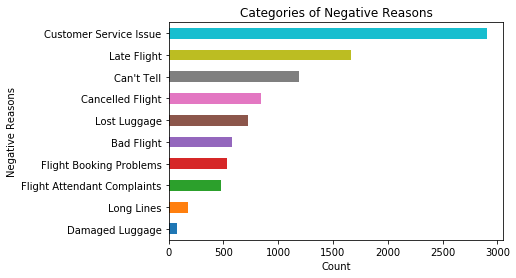

In [69]:
# Count of category occurence in data

# df.negativereason.value_counts().plot(kind = "bar")
# negreas = df.negativereason.value_counts(sort=True)

negreas = df.negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.title('Categories of Negative Reasons')

Text(0.5,1,'Negative Reason by Airline')

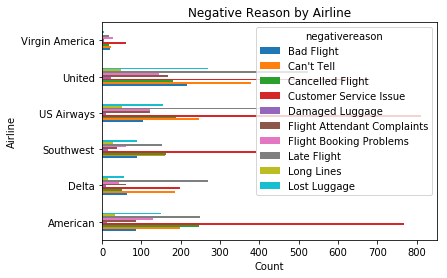

In [67]:
air_neg_sentiment=pd.crosstab(df.airline, df.negativereason).plot(kind='barh')
air_neg_sentiment
plt.xlabel('Count')
plt.ylabel('Airline')
plt.title('Negative Reason by Airline')

# Look at Ratios instead of counts

Text(0.5,1,'Categories of Negative Reasons: United Airlines')

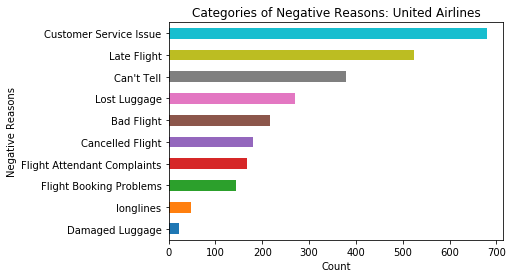

In [107]:
# Count of category occurence for United.

negreas = df[df.airline=='United'].negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.title('Categories of Negative Reasons: United Airlines')

Text(0.5,1,'Categories of Negative Reasons: Virgin America')

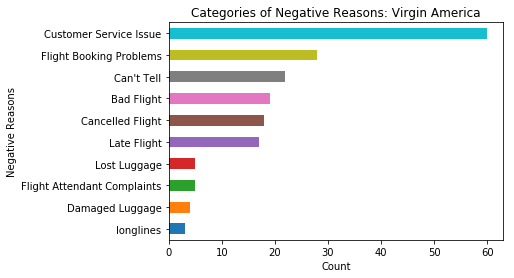

In [110]:
# Count of category occurence for Virgin.

negreas = df[df.airline=='Virgin America'].negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.title('Categories of Negative Reasons: Virgin America')

In [5]:
df.user_timezone.value_counts()

Eastern Time (US & Canada)     3744
Central Time (US & Canada)     1931
Pacific Time (US & Canada)     1208
Quito                           738
Atlantic Time (Canada)          497
Mountain Time (US & Canada)     369
Arizona                         229
London                          195
Alaska                          108
Sydney                          107
Hawaii                          104
Amsterdam                        74
America/Chicago                  37
Indiana (East)                   26
America/New_York                 26
Paris                            25
Brasilia                         23
Abu Dhabi                        23
Dublin                           17
Santiago                         17
Greenland                        17
Tehran                           17
Athens                           16
America/Los_Angeles              15
New Delhi                        15
Mid-Atlantic                     15
Casablanca                       15
Buenos Aires                

In [32]:
df.tweet_location.value_counts()

Boston, MA                        157
New York, NY                      156
Washington, DC                    150
New York                          127
USA                               126
Chicago                           104
New York City                      96
Los Angeles, CA                    96
NYC                                95
San Francisco, CA                  91
San Francisco                      86
Chicago, IL                        81
Brooklyn, NY                       66
Los Angeles                        64
Austin, TX                         64
Washington, D.C.                   63
Boston                             62
Dallas, TX                         54
Washington DC                      53
Nashville, TN                      45
Texas                              42
NY                                 42
Philadelphia, PA                   38
San Diego                          38
Denver, CO                         37
Houston, TX                        35
Global      

In [44]:
print(df.text[0])

@VirginAmerica What @dhepburn said.


In [45]:
print(df.text[1])

@VirginAmerica plus you've added commercials to the experience... tacky.


In [46]:
print(df.text[2])

@VirginAmerica I didn't today... Must mean I need to take another trip!


In [47]:
print(df.text[3])

@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse


In [48]:
print(df.text[5])

@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA


In [4]:
print(df.text[6])

@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)


In [3]:
# Research how to handle emojis

## Preprocessing

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Will\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [7]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Will\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [117]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

new_stopwords = ['http', 'amp', 'u', 'co']
stop_words = stop_words.union(new_stopwords)

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ", tweet)
    tokens = nltk.word_tokenize(only_letters)[2:] 
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [112]:
normalizer('This is a test of the normalizer to see what it does with a set of words and http:// and &amp and & and Capital PALABRAS')

['test', 'normalizer', 'see', 'set', 'word', 'capital', 'palabras']

In [55]:
'''
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(string):
    string = string.lower()
    string = re.sub(r"\@[a-z]+", "", string)  # remove the @airline
    string = re.sub(r"http\S+", "", string)  
    string = re.sub(r"&amp", "&", string)
    string = re.sub(r"[^a-z0-9\s]", "", string)  # remove most punctuation
    tokens = nltk.word_tokenize(string)
    
    lower_case = [l.lower() for l in tokens]    
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas
'''

In [92]:
# normalizer('This is a test of the normalizer to see what it does with a set of words and http:// and &amp and & and Capital PALABRAS')

In [118]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df['normalized_tweet'] = df.text.apply(normalizer)
df[['text','normalized_tweet']].head()

,text,normalized_tweet
0,@VirginAmerica What @dhepburn said.,"[dhepburn, said]"
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[added, commercial, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[today, must, mean, need, take, another, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guest, face, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"


In [119]:
import collections
def count_words(input):
    total_count = collections.Counter()
    for row in input:
        for word in row:
            total_count[word] += 1
    return total_count

In [115]:
# Test to not include retweets

# how do I incorporate - if df.retweet_count == 0:

import collections
def count_words(input):
    total_count = collections.Counter()
    for row in input:
        for word in row:
                total_count[word] += 1
    return total_count

In [120]:
df[(df.airline_sentiment == 'negative')][['normalized_tweet']].apply(count_words)['normalized_tweet'].most_common(20)

[('flight', 3162),
 ('hour', 1062),
 ('get', 1009),
 ('cancelled', 881),
 ('service', 767),
 ('customer', 760),
 ('time', 744),
 ('bag', 653),
 ('hold', 612),
 ('help', 608),
 ('plane', 598),
 ('call', 502),
 ('u', 484),
 ('delayed', 477),
 ('day', 456),
 ('flightled', 448),
 ('one', 444),
 ('still', 441),
 ('gate', 417),
 ('need', 409)]

In [136]:
single_words = df[(df.airline_sentiment == 'negative')][['normalized_tweet']].apply(count_words)['normalized_tweet'].most_common(20)
single_words

[('flight', 3162),
 ('hour', 1062),
 ('get', 1009),
 ('cancelled', 881),
 ('service', 767),
 ('customer', 760),
 ('time', 744),
 ('bag', 653),
 ('hold', 612),
 ('help', 608),
 ('plane', 598),
 ('call', 502),
 ('u', 484),
 ('delayed', 477),
 ('day', 456),
 ('flightled', 448),
 ('one', 444),
 ('still', 441),
 ('gate', 417),
 ('need', 409)]

In [192]:
single_words = pd.DataFrame(single_words)
single_words.set_index(single_words[0], inplace=True)


In [187]:
single_words

,0,1
0,,
flight,flight,3162
hour,hour,1062
get,get,1009
cancelled,cancelled,881
service,service,767
customer,customer,760
time,time,744
bag,bag,653
hold,hold,612


In [224]:
# single_words = single_words.sort_values(by=single_words[1],ascending=False)


Text(0.5,1,'Negative Reasons: Count of Single Words')

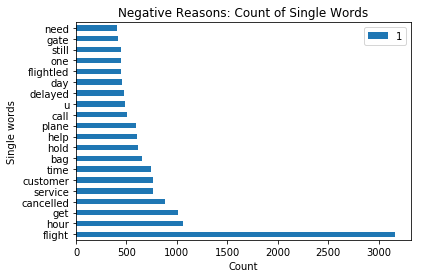

In [188]:
# Count of single words

single_words.plot.barh()
plt.xlabel('Count')
plt.ylabel('Single words')
plt.title('Negative Reasons: Count of Single Words')

In [121]:
df[(df.airline_sentiment == 'positive')][['normalized_tweet']].apply(count_words)['normalized_tweet'].most_common(20)

[('flight', 416),
 ('thanks', 298),
 ('thank', 217),
 ('great', 183),
 ('service', 163),
 ('guy', 123),
 ('customer', 121),
 ('get', 120),
 ('love', 116),
 ('time', 109),
 ('much', 108),
 ('airline', 107),
 ('best', 100),
 ('good', 99),
 ('u', 91),
 ('help', 86),
 ('today', 81),
 ('got', 79),
 ('crew', 78),
 ('jetblue', 74)]

In [122]:
from nltk import ngrams
def ngrams(initial_list):
    bigrams = [' '.join(t) for t in list(zip(initial_list, initial_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(initial_list, initial_list[1:], initial_list[2:]))]
    return bigrams + trigrams

df['multi_grams'] = df.normalized_tweet.apply(ngrams)
df[['multi_grams']].head()

,multi_grams
0,[dhepburn said]
1,"[added commercial, commercial experience, experience tacky, added commercial experience, commercial experience tacky]"
2,"[today must, must mean, mean need, need take, take another, another trip, today must mean, must mean need, mean need take, need take another, take another trip]"
3,"[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guest, guest face, face little, little recourse, really aggressive blast, aggressive blast obnoxious, blast obnoxious entertainment, obnoxious entertainment guest, entertainment guest face, guest face little, face little recourse]"
4,"[really big, big bad, bad thing, really big bad, big bad thing]"


In [123]:
df[(df.airline_sentiment == 'negative')][['multi_grams']].apply(count_words)['multi_grams'].most_common(20)

[('customer service', 438),
 ('cancelled flightled', 425),
 ('late flight', 215),
 ('cancelled flighted', 196),
 ('flight cancelled', 187),
 ('late flightr', 144),
 ('cancelled flight', 131),
 ('hold hour', 128),
 ('flightled flight', 123),
 ('flight cancelled flightled', 119),
 ('flight delayed', 115),
 ('cancelled flightled flight', 107),
 ('call back', 106),
 ('booking problem', 98),
 ('gate agent', 83),
 ('flight flight', 75),
 ('hour late', 69),
 ('delayed flight', 69),
 ('flight attendant', 60),
 ('cancelled flight flight', 56)]

In [124]:
df[(df.airline_sentiment == 'positive')][['multi_grams']].apply(count_words)['multi_grams'].most_common(20)

[('customer service', 91),
 ('flight attendant', 25),
 ('quick response', 19),
 ('great flight', 17),
 ('best airline', 16),
 ('great job', 16),
 ('great service', 16),
 ('gate agent', 16),
 ('thank much', 16),
 ('booking problem', 15),
 ('thanks help', 15),
 ('good work', 14),
 ('fleet fleek', 14),
 ('guy rock', 13),
 ('looking forward', 13),
 ('flight crew', 13),
 ('great customer', 12),
 ('great customer service', 12),
 ('keep good', 12),
 ('keep good work', 12)]

In [239]:
words = []
for word in df['text']:
    words.append(word)

In [240]:
print(words[20])

@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???


In [229]:
words = []
for word in df['normalized_tweet']:
    words.append(word)

In [230]:
print(words[20])

['first', 'fare', 'may', 'three', 'time', 'carrier', 'seat', 'available', 'select']


In [241]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(words, test_size=0.4, random_state=0)

In [242]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Creating Vectorizer and transforming data
cv = TfidfVectorizer(ngram_range=(1,3), stop_words='english', strip_accents='unicode')
tf = cv.fit_transform(df.text)

In [243]:
print("Number of features: %d" % tf.get_shape()[1])

Number of features: 201002


In [244]:
#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(tf, test_size=0.4, random_state=0)


### I copied this from the Thinkful course material as a placeholder.



#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = cv.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[0])
print('Tf_idf vector:', tfidf_bypara[0])

Original sentence: @USAirways 
Not one to complain much but really 1 hour 15minutes and still nothing. Agents or Agent ⤵ http://t.co/Q5SB0DaVuy
Tf_idf vector: {'agent http q5sb0davuy': 0.23157987981477687, 'agents agent http': 0.23157987981477687, '15minutes agents agent': 0.23157987981477687, 'hour 15minutes agents': 0.23157987981477687, 'really hour 15minutes': 0.23157987981477687, 'complain really hour': 0.23157987981477687, 'usairways complain really': 0.23157987981477687, 'http q5sb0davuy': 0.23157987981477687, 'agents agent': 0.23157987981477687, '15minutes agents': 0.23157987981477687, 'hour 15minutes': 0.23157987981477687, 'really hour': 0.23157987981477687, 'complain really': 0.23157987981477687, 'usairways complain': 0.23157987981477687, 'q5sb0davuy': 0.23157987981477687, 'agent http': 0.21536328007614713, '15minutes': 0.22209377707847397, 'usairways': 0.060552934567922885, 'complain': 0.18605412871949661, 'agents': 0.13025974013329006, 'agent': 0.11752167420637225, 'http': 0